실용적으로 의미있는 분 단위 이상의 음악을 고품질로 만들어내는데 처음 성공한 모델은 2018년에 Google의 Magenta 프로젝트에서 발표한 Music Transformer 모델이었습니다.

일단은 Transformer 기반의 모델이 음악 내의 반복구조의 통일성을 학습하고 재현해 내는 능력을 갖추게 되면서 음악 생성 모델 기술이 발전하기 시작했다는 것을 알아둡시다.m

### MuseNet
2019년 초가 되면서 OpenAI에서 GPT-2라는 Transformer 기반의 pretrained model을 통해 깜짝 놀랄 만큼의 텍스트 생성 기술을 선보였습니다. GPT-2는 처음으로 신문기사 정도 길이의 텍스트에서 주제의 통일성을 유지하면서 그럴듯한 작문 실력을 보여줌으로써 당시 세상을 깜짝 놀라게 했습니다. 그로부터 1달 정도 지났을 무렵 OpenAI에서는 GPT-2 모델을 좀더 개선하여 MuseNet이라는 음악 생성 모델을 발표했습니다.

MuseNet 블로그에서 음원 샘플을 들어보시기 바랍니다. MuseNet은 Sparse Transformer라는 모델 구조를 GPT-2 방식으로 학습하여, 상업적으로도 가치를 가질 수 있는 3~4분 이상의 음원을 음악 구조를 유지하면서 고퀄리티로 합성해 내는데 성공했습니다.

, MuseNet은 작곡가 혹은 음악 장르 임베딩까지 함께 학습하여, 특정 음악가(예를 들어 베토벤 등)의 음악적 특징과 개성까지 살려내는 음악 생성 모델을 보여 줌으로써 더욱 큰 반향을 불러일으켰습니다. https://openai.com/blog/musenet/

### Jukebox
MuseNet이 기악 분야의 음악 합성을 성공적으로 진행했지만, 사람의 목소리 특성까지 살려야 하는 성악 음악 합성은 여전히 어려운 과제였습니다. 그러나 2020년이 되면서 OpenAI에서 Jukebox라는 모델을 발표하면서 특정 가수의 음색, 음정과 가사전달까지 가능해진 더욱 발전된 음악 합성 모델을 선보이게 되었습니다.https://openai.com/blog/jukebox/

## 30-3. Music Transformer 시스템 개요
음악 생성모델 전체 구조
Music Transformer 를 활용한 음악 생성모델 전체 구조는 아래 그림과 같습니다. 크게 3부분으로 이루어집니다.

Transcription : 학습용 wave파일을 MIDI 파일로 바꿔주는 Wave2Midi 파트

Symbolic Modeling : 변환된 MIDI 파일을 생성하는 심볼릭 음악 생성 모델. Music Transformer가 이 부분에 해당

Synthesis : 생성된 MIDI 파일을 다시 wave로 바꿔주는 MIDI2Wave 합성 모델. Conditional WaveNet 모델이 사용됨

### 그래서 음악 합성 모델은 Wave2Midi2Wave 모델로 흔히 일컬어집니다.

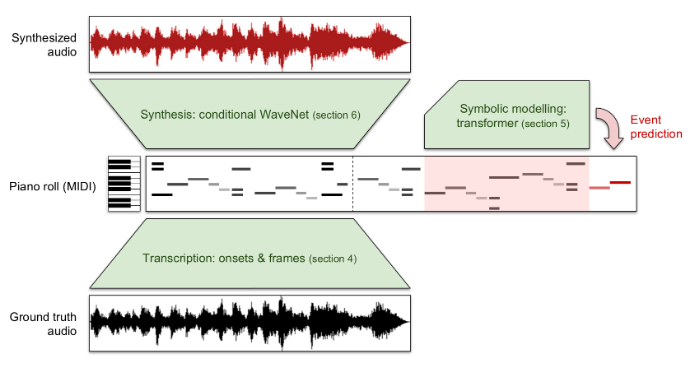

### Memory-Effective Relative-Global Attention Model

Music Transformer 모델은 아주 긴 길이의 MIDI 파일을 처리할 수 있어야 합니다. Vanilla Transformer 모델이 최대 512 step의 시퀀스를 예측한다면, Music Transformer 모델은 0.1초짜리 MIDI 스텝을 3000 스텝을 처리해야 300초, 즉 5분 길이의 음성을 합성할 수 있게 됩니다. (실제로는 한 스텝이 0.1초보다 짧습니다. 그리고 Music Transformer 모델은 L=3500 스텝을 처리하게 됩니다.

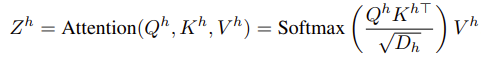

위 식은 Vanilla Transformer가 가지는 Self-Attention 수식입니다. attention matrix가 Q와 K의 내적으로 이루어지므로 연산량이 에 비례하게 됩니다.

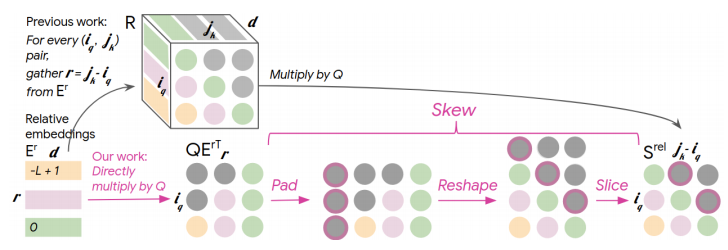

### 30-4. MAESTRO 데이터셋
MAESTRO 데이터셋
Google이 Magenta 프로젝트에서 공개한 MAESTRO 데이터셋은 200시간에 해당하는 피아노 연주 음원 및 이를 MIDI로 변환한 파일을 음악 합성 데이터셋으로 제공하는 공개 데이터셋입니다. Music Transformer는 바로 이 데이터셋을 기반으로 학습된 것입니다. 오늘 우리도 이 데이터셋을 활용해서 Music Transformer 모델을 학습시켜볼 것입니다.

In [69]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np

import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import concurrent.futures

import mido



[]

In [70]:
# 샘플로 1개의 MIDI 파일을 골라봅니다.
midi_file = os.getenv('HOME')+'/aiffel/music_transformer/data/maestro-v2.0.0/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi'

midi = mido.MidiFile(midi_file)

MIDI 파일을 열어보면 이벤트의 리스트(list)로 구성되어 있음을 알 수 있습니다. 아래 코드를 통해 MIDI 파일 앞부분의 30개 정도의 이벤트 구조가 어떻게 되어 있는지 파악해 봅시다.

In [30]:
ON = 1
OFF = 0
CC = 2

current_time = 0
eventlist = []
cc = False
for idx, msg in enumerate(midi):
    print('MSG [{}]----------------'.format(idx))
    current_time += msg.time
    print(current_time)
    print(msg.type)
    if msg.type is 'note_on' and msg.velocity > 0:
        event = [current_time, ON, msg.note, msg.velocity]
        print(event)
    elif msg.type is 'note_off' or (msg.type is 'note_on' and msg.velocity == 0):
        event = [current_time, OFF, msg.note, msg.velocity]
        print(event)
        
    if msg.type is 'control_change':
        if msg.control != 64:
            continue
        if cc == False and msg.value > 0:
            cc = True
            event = [current_time, CC, 0, 1]
            print(event)
        elif cc == True and msg.value == 0:
            cc = False
            event = [current_time, CC, 0, 0]
            print(event)

    if idx > 30:
        break

MSG [0]----------------
0
set_tempo
MSG [1]----------------
0
time_signature
MSG [2]----------------
0
program_change
MSG [3]----------------
0
control_change
MSG [4]----------------
0
control_change
MSG [5]----------------
0.5143229166666666
control_change
MSG [6]----------------
0.6328125
control_change
MSG [7]----------------
0.7903645833333333
control_change
MSG [8]----------------
0.9999999999999999
control_change
MSG [9]----------------
1.0325520833333333
note_on
[1.0325520833333333, 1, 74, 86]
MSG [10]----------------
1.0442708333333333
note_on
[1.0442708333333333, 1, 38, 77]
MSG [11]----------------
1.0794270833333333
control_change
MSG [12]----------------
1.1184895833333333
control_change
MSG [13]----------------
1.1588541666666665
control_change
MSG [14]----------------
1.2174479166666665
control_change
MSG [15]----------------
1.2265624999999998
note_on
[1.2265624999999998, 0, 74, 0]
MSG [16]----------------
1.2369791666666665
control_change
MSG [17]----------------
1.23958

MIDI 앞부분의 이벤트 메시지 타입은 control_change 등의 세팅 부분이고, 실제 악보 부분은 note_on 메시지를 통해 구현됩니다. 위 코드에서 이벤트 구조는 [음 지속시간, ON/OFF, 음고(pitch), 속도(velocity)]에 해당합니다.



오늘 실험을 위해 MIDI 파일을 일부 전처리한 파일을 함께 제공하겠습니다. 전처리 로직은 아래 get_data()를 통해 구현되었습니다. 단순히 MIDI 파일을 가공만 한 것이 아니라 time, note, interval 등에 대한 augmentation까지 함께 진행하는 것입니다.

In [31]:
IntervalDim = 100

VelocityDim = 32
VelocityOffset = IntervalDim

NoteOnDim = NoteOffDim = 128


NoteOnOffset = IntervalDim + VelocityDim
NoteOffOffset = IntervalDim + VelocityDim + NoteOnDim

CCDim = 2
CCOffset = IntervalDim + VelocityDim + NoteOnDim + NoteOffDim

 
EventDim = IntervalDim + VelocityDim + NoteOnDim + NoteOffDim + CCDim # 390

def get_data(data, length):    
    # time augmentation
    data[:, 0] *= np.random.uniform(0.80, 1.20)
    
    # absolute time to relative interval
    data[1:, 0] = data[1:, 0] - data[:-1, 0]
    data[0, 0] = 0
    
    # discretize interval into IntervalDim
    data[:, 0] = np.clip(np.round(data[:, 0] * IntervalDim), 0, IntervalDim - 1)
    
    # Note augmentation
    data[:, 2] += np.random.randint(-6, 6)
    data[:, 2] = np.clip(data[:, 2], 0, NoteOnDim - 1)
    
    eventlist = []
    for d in data:
        # append interval
        interval = d[0]
        eventlist.append(interval)
    
        # note on case
        if d[1] == 1:
            velocity = (d[3] / 128) * VelocityDim + VelocityOffset
            note = d[2] + NoteOnOffset
            eventlist.append(velocity)
            eventlist.append(note)
            
        # note off case
        elif d[1] == 0:
            note = d[2] + NoteOffOffset
            eventlist.append(note)
        # CC
        elif d[1] == 2:
            event = CCOffset + d[3]
            eventlist.append(event)
            
    eventlist = np.array(eventlist).astype(np.int)
    
    if len(eventlist) > (length+1):
        start_index = np.random.randint(0, len(eventlist) - (length+1))
        eventlist = eventlist[start_index:start_index+(length+1)]
        
    # pad zeros
    if len(eventlist) < (length+1):
        pad = (length+1) - len(eventlist)
        eventlist = np.pad(eventlist, (pad, 0), 'constant')
        
    x = eventlist[:length]
    y = eventlist[1:length+1]
    
    return x, y

In [32]:
#!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/midi_test.zip

In [33]:
#!mv midi_test.zip ~/aiffel/music_transformer/data

In [34]:
#!unzip midi_test.zip

### 30-5. Music Transformer 모델 구현


In [35]:
data_path = os.getenv('HOME')+'/aiffel/music_transformer/data/midi_test.npy'

get_midi = np.load(data_path, allow_pickle=True)
get_midi.shape

(1282,)

In [36]:
tf.config.list_physical_devices('GPU')

[]

In [37]:
length = 256
train = []
labels = []

for midi_list in get_midi:
    cut_list = [midi_list[i:i+length] for i in range(0, len(midi_list), length)]
    for sublist in cut_list:
        x, y = get_data(np.array(sublist), length)
        train.append(x)
        labels.append(y)

In [38]:
train = np.array(train)
labels = np.array(labels)

print(train.shape, labels.shape)   # 학습을 위해 MIDI list를 256 길이로 나누었다.

(59268, 256) (59268, 256)


256의 길이를 가지는 59268개의 시퀀스가 생성되었습니다. label은 train 데이터를 1만큼 shift한 것입니다.

우리 데이터셋은 마치 자연어처리에서의 language model 훈련용 데이터셋같은 구성을 가집니다. 그래서 데이터셋을 구성하는 기법도 비슷해집니다.

In [39]:
train_data_pad = pad_sequences(train,
                               maxlen=length,
                               padding='post',
                               value=0)
train_label_pad = pad_sequences(labels,
                                maxlen=length,
                                padding='post',
                                value=0)

In [40]:
def tensor_casting(train, label):
    train = tf.cast(train, tf.int64)
    label = tf.cast(label, tf.int64)

    return train, label

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_pad, train_label_pad))
train_dataset = train_dataset.map(tensor_casting)
train_dataset = train_dataset.shuffle(10000).batch(batch_size=16)

배치사이즈는 16 정도가 적당할 것입니다. 16GB RAM을 가진 모델에서 32 정도의 배치사이즈는 메모리 오류가 발생할 가능성이 있습니다.



In [42]:
for t,l in train_dataset.take(1):
    print(t)
    print(l)

tf.Tensor(
[[330  15 118 ... 197   0 117]
 [  2 322   2 ... 206   1 112]
 [  3 111 179 ...   1 120 191]
 ...
 [109 179   5 ...   1 332   1]
 [196   4 314 ... 198   1 389]
 [202   9 120 ... 205   4 333]], shape=(16, 256), dtype=int64)
tf.Tensor(
[[ 15 118 205 ...   0 117 206]
 [322   2 316 ...   1 112 183]
 [111 179   1 ... 120 191   5]
 ...
 [179   5 307 ... 332   1 308]
 [  4 314   8 ...   1 389  10]
 [  9 120 190 ...   4 333   3]], shape=(16, 256), dtype=int64)


## Music Transformer 모델 구현
이제 본격적으로 모델을 구현해 봅시다

In [43]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 1), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


def create_look_ahead_mask(size):
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

아래 레이어가 Music Transformer의 가장 핵심적인 원리를 구성하는 RelativeGlobalAttention 으로서, self-attention 을 대신하여 사용됩니다.

In [44]:
class RelativeGlobalAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(RelativeGlobalAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.headDim = d_model // num_heads
        self.contextDim = int(self.headDim * self.num_heads)
        self.eventDim = 390
        self.E = self.add_weight('E', shape=[self.num_heads, length, self.headDim])

        assert d_model % self.num_heads == 0

        self.wq = tf.keras.layers.Dense(self.headDim)
        self.wk = tf.keras.layers.Dense(self.headDim)
        self.wv = tf.keras.layers.Dense(self.headDim)
    
    def call(self, v, k, q, mask):
        # [Heads, Batch, Time, HeadDim]
        q = tf.stack([self.wq(q) for _ in range(self.num_heads)])
        k = tf.stack([self.wk(k) for _ in range(self.num_heads)])
        v = tf.stack([self.wv(v) for _ in range(self.num_heads)])

        self.batch_size = q.shape[1]
        self.max_len = q.shape[2]
        
        #skewing
        # E = Heads, Time, HeadDim
        # [Heads, Batch * Time, HeadDim]
        Q_ = tf.reshape(q, [self.num_heads, self.batch_size * self.max_len, self.headDim])
        # [Heads, Batch * Time, Time]
        S = tf.matmul(Q_, self.E, transpose_b=True)
        # [Heads, Batch, Time, Time]
        S = tf.reshape(S, [self.num_heads, self.batch_size, self.max_len, self.max_len])
        # [Heads, Batch, Time, Time+1]
        S = tf.pad(S, ((0, 0), (0, 0), (0, 0), (1, 0)))
        # [Heads, Batch, Time+1, Time]
        S = tf.reshape(S, [self.num_heads, self.batch_size, self.max_len + 1, self.max_len])   
        # [Heads, Batch, Time, Time]
        S = S[:, :, 1:]
        # [Heads, Batch, Time, Time]
        attention = (tf.matmul(q, k, transpose_b=True) + S) / np.sqrt(self.headDim)
        # mask tf 2.0 == tf.linalg.band_part
        get_mask = tf.linalg.band_part(tf.ones([self.max_len, self.max_len]), -1, 0)
        attention = attention * get_mask - tf.cast(1e10, attention.dtype) * (1-get_mask)
        score = tf.nn.softmax(attention, axis=3)

        # [Heads, Batch, Time, HeadDim]
        context = tf.matmul(score, v)
        # [Batch, Time, Heads, HeadDim]
        context = tf.transpose(context, [1, 2, 0, 3])
        # [Batch, Time, ContextDim]
        context = tf.reshape(context, [self.batch_size, self.max_len, self.d_model])
        # [Batch, Time, ContextDim]
        logits = tf.keras.layers.Dense(self.d_model)(context)

        return logits, score

In [45]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.rga = RelativeGlobalAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.rga(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [46]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.rga1 = RelativeGlobalAttention(d_model, num_heads)
        self.rga2 = RelativeGlobalAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.rga1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.rga2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [47]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
        super(Encoder, self).__init__()

        self.num_layers = num_layers
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [48]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attention_weights = {}
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [49]:
class MusicTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        super(MusicTransformer, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, rate)

        self.final_layer = tf.keras.layers.Dense(input_vocab_size)

    def call(self, inp, training, enc_padding_mask, 
             look_ahead_mask, dec_padding_mask):
        embed = self.embedding(inp)
        embed *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        enc_output = self.encoder(embed, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            embed, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

 일반적인 Transformer Encoder-Decoder 모델과 거의 같은 구조를 가지지만 Self-Attention 레이어가 RelativeGlobalAttention 로 바뀌었다는 차이만 있습니다.

RelativeGlobalAttention 레이어 구조를 유심히 파악해 주세요.

## 30-6. Music Transformer 모델 학습
이전 스텝에서 구현한 Music Transformer 모델을 활용하여 실제 학습을 진행해 보겠습니다.

In [50]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = 390   # MIDI가 낼 수 있는 소리의 종류
dropout_rate = 0.1

In [51]:
# 모델 선언
music_transformer = MusicTransformer(num_layers, d_model, num_heads, dff,
                                     input_vocab_size, rate=dropout_rate)

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [53]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

language model이 다음에 올 단어를 맞추는 classification task 구성을 가지는 것처럼, MIDI 생성 모델도 390가지 음향 종류 중 어느 것이 올지를 맞추는 문제로 구성하였으므로 아래와 같이 SparseCategoricalCrossentropy로 loss 함수를 정의합니다.

In [54]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [55]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [56]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [57]:
checkpoint_path = os.getenv('HOME')+'/aiffel/music_transformer/models/'

ckpt = tf.train.Checkpoint(music_transformer=music_transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

이제 모델 학습에 들어갑니다.

(주의) 이 모델은 총 20epoch를 학습해야 하지만, 1epoch만 학습하는 데도 1시간 가까운 시간이 소요됩니다. 따라서 당일 전체 모델학습을 마무리하는 것은 무리스러우므로 1epoch만 학습을 진행해 보겠습니다.

In [58]:
#EPOCHS = 20  
EPOCHS = 2  # 1epoch가 매우 오래 걸립니다. 

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            predictions, _ = music_transformer(inp, True, None, None, None)
            loss = loss_function(tar, predictions)

        gradients = tape.gradient(loss, music_transformer.trainable_variables)    
        optimizer.apply_gradients(zip(gradients, music_transformer.trainable_variables))

        train_loss(loss)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, train_loss.result()))

    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 6.1977
Epoch 1 Batch 50 Loss 6.2617
Epoch 1 Batch 100 Loss 6.2032
Epoch 1 Batch 150 Loss 6.1298
Epoch 1 Batch 200 Loss 6.0272
Epoch 1 Batch 250 Loss 5.8994
Epoch 1 Batch 300 Loss 5.7665
Epoch 1 Batch 350 Loss 5.6438
Epoch 1 Batch 400 Loss 5.5378
Epoch 1 Batch 450 Loss 5.4507
Epoch 1 Batch 500 Loss 5.3785
Epoch 1 Batch 550 Loss 5.3135
Epoch 1 Batch 600 Loss 5.2280
Epoch 1 Batch 650 Loss 5.1409
Epoch 1 Batch 700 Loss 5.0486
Epoch 1 Batch 750 Loss 4.9606
Epoch 1 Batch 800 Loss 4.8804
Epoch 1 Batch 850 Loss 4.8096
Epoch 1 Batch 900 Loss 4.7463
Epoch 1 Batch 950 Loss 4.6888
Epoch 1 Batch 1000 Loss 4.6359
Epoch 1 Batch 1050 Loss 4.5878
Epoch 1 Batch 1100 Loss 4.5448
Epoch 1 Batch 1150 Loss 4.5045
Epoch 1 Batch 1200 Loss 4.4676
Epoch 1 Batch 1250 Loss 4.4335
Epoch 1 Batch 1300 Loss 4.4020
Epoch 1 Batch 1350 Loss 4.3726
Epoch 1 Batch 1400 Loss 4.3454
Epoch 1 Batch 1450 Loss 4.3195
Epoch 1 Batch 1500 Loss 4.2950
Epoch 1 Batch 1550 Loss 4.2718
Epoch 1 Batch 1600 Loss 4.2500


매 2 epoch마다 checkpoint를 저장하도록 구성하였습니다. 1epoch만 학습시 모델이 저장되지 않음에 유의해 주세요.

In [ ]:
#!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/models.zip

In [ ]:
#!mv models.zip ~/aiffel/music_transformer/models

In [ ]:
#!cd ~/aiffel/music_transformer/models && unzip models.zip

In [59]:
tf.train.latest_checkpoint(checkpoint_path)

'/home/aiffel0042/aiffel/music_transformer/models/ckpt-1'

테스트용 데이터셋을 별도로 분리하지 않았으므로, 학습에 사용했던 데이터를 다시 활용하겠습니다. 그러나 이 데이터는 실제로는 첫번째 스텝의 데이터만 활용될 것입니다.

In [60]:
test_dataset = tf.data.Dataset.from_tensor_slices((train_data_pad, train_label_pad))
test_dataset = test_dataset.map(tensor_casting)
test_dataset = test_dataset.shuffle(10000).batch(batch_size=1)

자연어처리의 text generation 모델처럼 inference 단계는 step-by-step으로 진행됩니다. for문을 돌면서 예측된 단어를 그 다음 입력으로 모델에 전달하는 구조를 눈여겨 봐주세요

In [61]:
N = 1000
_inputs = np.zeros([1, N], dtype=np.int32)

for x, y in test_dataset.take(1):
    _inputs[:, :length] = x[None, :]
    
for i in range(N - length):
    predictions, _ = music_transformer(_inputs[:, i:i+length], False, None, None, None)
    predictions = tf.squeeze(predictions, 0)    
    
    # select the last word from the seq_len dimension
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    print(predicted_id)
    
    # 예측된 단어를 다음 입력으로 모델에 전달
    # 이전 은닉 상태와 함께
    _inputs[:, i+length] = predicted_id

_inputs.shape

27
121
221
1
124
192
1
340
1
355
3
296
10
124
229
1
121
215
2
120
210
3
123
125
199
2
388
3
123
218
1
122
217
1
313
1
118
209
8
122
211
1
124
220
3
388
1
109
200
1
331
14
101
220
5
388
5
293
1
317
1
345
14
121
216
6
293
15
331
4
121
220
1
292
6
338
9
120
218
4
329
10
125
220
8
389
11
121
186
2
349
8
126
204
1
336
13
125
210
2
119
199
5
292
8
119
208
3
121
203
10
389
6
317
2
120
176
1
388
15
120
193
8
322
1
113
209
1
325
2
388
10
119
211
4
115
200
2
332
5
331
14
388
4
323
1
323
10
124
206
5
119
209
2
114
180
6
124
206
9
120
192
5
119
185
7
328
1
302
1
124
220
1
118
209
2
123
205
12
388
5
333
1
348
3
333
7
334
1
122
173
4
123
207
3
320
3
325
1
121
211
1
120
203
2
114
180
14
117
167
8
317
1
120
204
7
304
3
312
3
333
12
121
200
2
121
193
6
327
5
306
25
122
165
2
120
206
2
388
1
125
200
2
320
5
119
179
41
124
186
2
311
13
117
174
1
117
209
14
122
210
3
330
3
119
200
16
124
207
1
307
10
122
201
1
118
194
3
338
3
120
201
2
333
10
119
193
2
326
3
347
8
329
12
119
204
19
389
11
337
7
115
198
2


(1, 1000)

우리의 Inference 결과가 _inputs 리스트 안에 잘 담겼습니다. 이제 이 내용을 다시 MIDI 파일로 복원해 내기 위해 아래와 같이 MIDI Event 클래스를 정의하였습니다.

In [63]:
class Event():
    def __init__(self, time, note, cc, on, velocity):
        self.time = time
        self.note = note
        self.on = on
        self.cc = cc
        self.velocity = velocity

    def get_event_sequence(self):
        return [self.time, self.note, int(self.on)]

class Note():
    def __init__(self):
        self.pitch = 0
        self.start_time = 0
        self.end_time = 0

그럼 _inputs 에 담긴 내용을 차례차례 MIDI Event로 변환해 보겠습니다.



In [80]:
IntervalDim = 80
# 노트를 연주하는 강세
VelocityDim = 64
# Note ON/OFF
NoteOnDim = NoteOffDim = 64

event_list = []
time = 0
event = None

EventDim = IntervalDim + VelocityDim + NoteOnDim + NoteOffDim # 388

for _input in _inputs[0]:
    # interval
    if _input < IntervalDim: 
        time += _input
        event = Event(time, 0, False, 0, 0)

    # velocity
    elif _input < NoteOnOffset:
        if event is None:
            continue
        event.velocity = (_input - VelocityOffset) / VelocityDim * 128

    # note on
    elif _input < NoteOffOffset:
        if event is None:
            continue

        event.note = _input - NoteOnOffset
        event.on = True
        event_list.append(event)

        event = None

    # note off
    elif _input < CCOffset:
        if event is None:
            continue
        event.note = _input - NoteOffOffset
        event.on = False
        event_list.append(event)
        event = None

    ## CC
    else:
        if event is None:
            continue
        event.cc = True
        on = _input - CCOffset == 1
        event.on = on
        event_list.append(event)
        event = None

#!sudo apt install timidity timidity-interfaces-extra

이제 마지막으로, MIDI Event로부터 MIDI 파일을 재구성해 보겠습니다.

In [81]:
from mido import Message, MidiFile, MidiTrack, MetaMessage, bpm2tempo

midi = MidiFile()
output_midi_path = os.getenv('HOME')+'/aiffel/music_transformer/data/output_file.mid'

# Instantiate a MIDI Track (contains a list of MIDI events)
track = MidiTrack()
track.append(MetaMessage("set_tempo", tempo=bpm2tempo(120)))
# Append the track to the pattern
midi.tracks.append(track)

prev_time = 0
pitches = [None for _ in range(128)]
for event in event_list:
    tick = (event.time - prev_time) // 3
    midi.ticks_per_beat = 8
    prev_time = event.time

    # case NOTE:
    if not event.cc:
        if event.on:
            if pitches[event.note] is not None:
                # Instantiate a MIDI note off event, append it to the track
                off = Message('note_off', note=event.note, velocity=0, time=0)
                track.append(off)
                pitches[event.note] = None

            # Instantiate a MIDI note on event, append it to the track
            on = Message('note_on', note=event.note, velocity=int(event.velocity), time=tick)
            track.append(on)
            pitches[event.note] = prev_time
        else:
            # Instantiate a MIDI note off event, append it to the track
            off = Message('note_off', note=event.note, velocity=0, time=tick)
            track.append(off)
            pitches[event.note] = None

#     case CC:
    elif event.cc:
        if event.on:
            cc = Message('control_change', control=64, time=tick, value=127)
        else:
            cc = Message('control_change', control=64, time=tick, value=0)

        track.append(cc)

    for pitch in range(128):
        if pitches[pitch] is not None and pitches[pitch] + 100 < prev_time:
            off = Message('note_off', note=pitch, velocity=0, time=0)
            track.append(off)
            pitches[pitch] = None


# Add the end of track event, append it to the track
track.append(MetaMessage("end_of_track"))

# Save the pattern to disk
midi.save(output_midi_path)

for i, track in enumerate(midi.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
        print(msg)

print('done')

Track 0: 
<meta message set_tempo tempo=500000 time=0>
note_off channel=0 note=73 velocity=0 time=1
note_off channel=0 note=78 velocity=0 time=0
note_off channel=0 note=82 velocity=0 time=0
note_on channel=0 note=75 velocity=34 time=3
note_on channel=0 note=87 velocity=38 time=0
note_on channel=0 note=79 velocity=34 time=0
note_on channel=0 note=82 velocity=28 time=0
note_off channel=0 note=75 velocity=0 time=0
note_off channel=0 note=87 velocity=0 time=0
note_off channel=0 note=79 velocity=0 time=0
note_off channel=0 note=70 velocity=0 time=0
note_off channel=0 note=82 velocity=0 time=0
note_on channel=0 note=75 velocity=36 time=2
note_on channel=0 note=87 velocity=40 time=0
note_on channel=0 note=79 velocity=36 time=0
note_on channel=0 note=82 velocity=32 time=0
note_off channel=0 note=75 velocity=0 time=0
note_off channel=0 note=79 velocity=0 time=0
note_off channel=0 note=87 velocity=0 time=0
note_off channel=0 note=82 velocity=0 time=0
note_on channel=0 note=75 velocity=36 time=3


mid 설치 프로그램이 작동이 안되 소리를 듣고싶었으나, 여러가지 문제로 들을수없었다.
소리는잘들린다고하니.. 생성은 잘된듯싶다.. 여러가지 상황에 맞는 소리를 재생할수있어서
비즈니스에 적용할 계획이 떠오른다

### 30-8. 프로젝트 : 다양한 조건의 음악 생성하기

초기값들을 다양하게 바꾸어 보면서 음악 생성을 테스트해 보시기 바랍니다. 모델과 초기 입력이 같더라도 매번의 시도에 따라 생성된 midi 파일이 달라집니다.

### STEP 1 : MAESTRO 데이터셋을 전처리하여 훈련용 데이터셋 구성하기


### STEP 2 : Music Transformer 모델을 구현하여 학습 진행하기
단, 20Epoch를 완전히 학습 진행해야 하는 것은 아닙니다. 하지만 최초의 체크포인트가 저장되는 2Epoch까지는 진행해 주세요.

### STEP 3 : 제공된 체크포인트 파일을 이용하여 다양한 midi 파일 생성하기
midi 파일을 생성하는 단계에서 바꾸어 볼 수 있는 조건에는 무엇이 있는지 찾아 보세요.
조건을 변경해 가며 5개 이상의 midi 파일을 생성해 보세요.
가장 잘 생성된 midi 파일을 첨부하여 제출해 주세요.